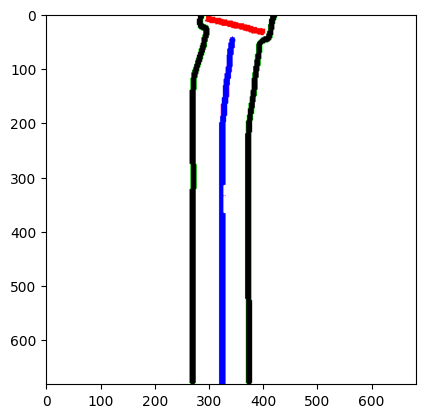

In [5]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2

path = 'gt_t'

img = cv2.imread('gt_t/0.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (682, 682))
img = np.rot90(img, 1)
img[(img.shape[0] // 2 - 30):(img.shape[0] // 2 + 30), (img.shape[1] // 2 - 10):(img.shape[1] // 2 + 13)] = 255
img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]

new_img = np.zeros((img.shape))

cur_frame_dots = []

for i in range(0, img.shape[0], 7):
    for j in range(0, img.shape[1], 6):
        if img[i, j] == [0, 0, 0]:
            # new_img[i, j] = 255
            cur_frame_dots.append((i, j, 0))
        elif img[i, j] == [255, 0, 0]:
            cur_frame_dots.append((i, j, 1))
        elif img[i, j] == [0, 0, 255]:
            cur_frame_dots.append((i, j, 2))

plt.gray()
# plt.imshow(new_img)
plt.imshow(img)
plt.show()



In [ ]:
img[200,250:350]

In [ ]:
# img segmentation map to sparse dot

import json

path = 'gt_t'

coord_dict = {}

floor_imgs = sorted(os.listdir('gt_t'), key=lambda x: int(x.split('.')[0]))

with open('result2ue5.json', 'r') as f:
    data = json.load(f)
    frame_keys = list(data.keys())
    for idx, frame_key in enumerate(frame_keys):

        

        img = cv2.imread(os.path.join(path, floor_imgs[idx]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (682, 682))
        img = np.rot90(img, 1)
        img[(img.shape[0] // 2 - 30):(img.shape[0] // 2 + 30), (img.shape[1] // 2 - 10):(img.shape[1] // 2 + 13)] = 255
        img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]

        new_img = np.zeros((img.shape))

        cur_frame_dots = []

        for i in range(0, img.shape[0], 7):
            for j in range(0, img.shape[1], 6):
                if list(img[i, j]) == [0, 0, 0]:
                    cur_frame_dots.append((i, j, 0))
                elif list(img[i, j]) == [255, 0, 0]:
                    cur_frame_dots.append((i, j, 1))
                elif list(img[i, j]) == [0, 0, 255]:
                    cur_frame_dots.append((i, j, 2))

        coord_dict[frame_key] = cur_frame_dots
        
    
with open('coord.json', 'w') as f:
    json.dump(coord_dict, f)

In [28]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import json
import imageio
from IPython.display import Image


with open('../JSONfiles/result2ue5.json', 'r') as f:
    data = json.load(f)
    f.close()

with open('../JSONfiles/coord.json', 'r') as f:
    floor_data = json.load(f)
    f.close()

img_arr = []

s_60_frame_idx = 0
s_ped_frame_idx = 5
cone_frame_idx = 31

for idx, frame_key in enumerate(list(data.keys())):
    # plt.figure(figsize=(10, 10))  # Set the size of the figure
    img = np.zeros((682, 682, 3), dtype=np.uint8)

    cur_frame_dots = floor_data[frame_key]
    cur_frame_objs = data[frame_key]
    cur_frame_objs_len = len(cur_frame_objs)

    if idx >= s_60_frame_idx:
        d_x = 390
        d_y = 50 + 45 * (idx - s_60_frame_idx)
        if d_x < img.shape[1] and d_y < img.shape[0]:
            cv2.circle(img, (d_x, d_y), 5, (0, 255, 255), -1)
            data[frame_key][cur_frame_objs_len] = {'x': d_x, 'y': d_y, 'track_id' : 999, 'class': 'sign_60', 'distance_ang' : -90, 'traj_point' : []}
            cur_frame_objs_len += 1
    
    if idx >= s_ped_frame_idx:
        d_x = 260
        d_y = 20 + 45 * (idx - s_ped_frame_idx)
        if d_x < img.shape[1] and d_y < img.shape[0]:
            cv2.circle(img, (d_x, d_y), 5, (255, 255, 0), -1)
            data[frame_key][cur_frame_objs_len] = {'x': d_x, 'y': d_y, 'track_id' : 999, 'class': 'sign_ped', 'distance_ang' : -90, 'traj_point' : []}
            cur_frame_objs_len += 1

    if idx >= cone_frame_idx:

        for j in range(5):
            d_x = 405
            d_y = 20 + 20 * j + 45 * (idx - cone_frame_idx)
            if d_x < img.shape[1] and d_y < img.shape[0]:
                cv2.circle(img, (d_x, d_y), 5, (255, 0, 255), -1)
                data[frame_key][cur_frame_objs_len] = {'x': d_x, 'y': d_y, 'track_id' : 999, 'class': 'cone', 'distance_ang' : -90, 'traj_point' : []}
                cur_frame_objs_len += 1

    for dot in cur_frame_dots:
        if dot[2] == 0:
            cv2.circle(img, (dot[1], dot[0]), 1, (0, 255, 0), -1)
        elif dot[2] == 1:
            cv2.circle(img, (dot[1], dot[0]), 1, (255, 0, 0), -1)
        elif dot[2] == 2:
            cv2.circle(img, (dot[1], dot[0]), 1, (0, 0, 255), -1)
    
    
    for obj_key in cur_frame_objs.keys():
        obj_dict = cur_frame_objs[obj_key]
        cv2.circle(img, (int(obj_dict['x']), int(obj_dict['y'])), 3, (255, 255, 255), -1)

        data[frame_key][obj_key]['traj_point'] = []

    # print('ID:', idx)
    # plt.imshow(img)
    # plt.show()


    img_arr.append(img)

# imageio.mimsave('../result2ue5.gif', img_arr, duration=0.1)

with open('../JSONfiles/result2ue5_add.json', 'w') as f:
    json.dump(data, f)
    f.close()


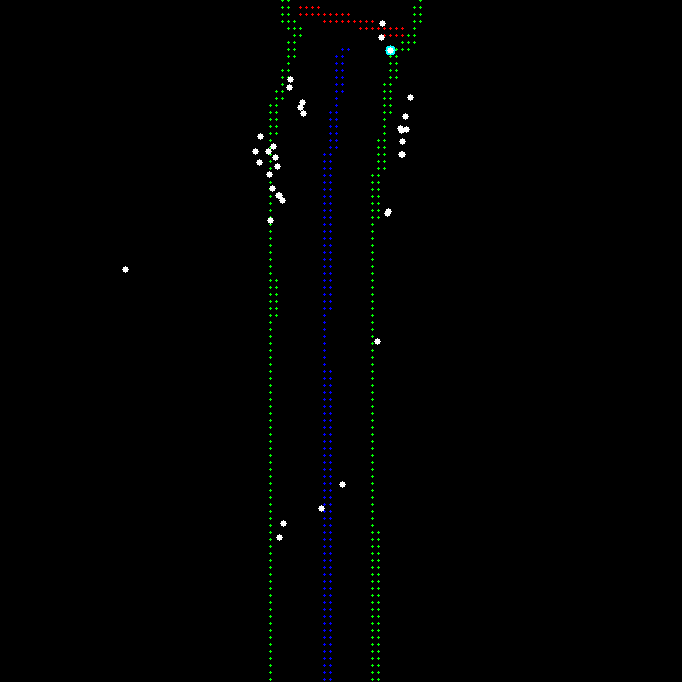

In [30]:
from IPython.display import Image

Image('../result2ue5.gif')




In [30]:
# create mono color texture
import cv2
import numpy as np
import matplotlib.pyplot as plt
img = np.zeros((1024, 1024, 3), np.uint8)
img[:, :, 0] = 255
cv2.imwrite('textures/roadline.png', img)

True